In [1]:
# Cell 1: Import required libraries
import os
import yaml
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import your model and data loading components
from dataloader.dataset_wrapper import create_wrapper_from_dataframe

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Configuration and paths setup
CONFIG_PATH = "/home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/services/CSU-MS2/model/qtof_model/median_energy/checkpoints/config.yaml"
CHECKPOINT_PATH = "/home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/services/CSU-MS2/CSUMS2/model/checkpoints/best_model.pth"  # Update this path
VALIDATION_CSV_PATH = "/home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/data/validation_deduplicated.csv"
OUTPUT_DIR = "./evaluation_results"

# Device selection for Mac
if torch.backends.mps.is_available():
    DEVICE = 'mps'
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
elif torch.cuda.is_available():
    DEVICE = 'cuda'
    print("Using CUDA for GPU acceleration")
else:
    DEVICE = 'cpu'
    print("Using CPU")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Validation data path: {VALIDATION_CSV_PATH}")
print(f"Checkpoint path: {CHECKPOINT_PATH}")

Using CUDA for GPU acceleration
Using device: cuda
Validation data path: /home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/data/validation_deduplicated.csv
Checkpoint path: /home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/services/CSU-MS2/CSUMS2/model/checkpoints/best_model.pth


In [4]:
# Cell 3: Load configuration
print("Loading configuration...")
config = yaml.load(open(CONFIG_PATH, "r"), Loader=yaml.FullLoader)

print("Configuration loaded:")
print(f"- Batch size: {config.get('batch_size', 'Not specified')}")
print(f"- Model config keys: {list(config.get('model', {}).keys())}")
print(f"- Loss config: {config.get('loss', {})}")

Loading configuration...
Configuration loaded:
- Batch size: 1024
- Model config keys: []
- Loss config: {'temperature': 0.1, 'use_cosine_similarity': True, 'alpha_weight': 0.75}


In [5]:
# Cell 4: Load and explore validation data
print("Loading validation data...")
df_validation = pd.read_csv(VALIDATION_CSV_PATH)

print(f"Validation dataset shape: {df_validation.shape}")
print(f"Columns: {list(df_validation.columns)}")
print(f"Sample data:")
df_validation.head()

Loading validation data...
Validation dataset shape: (160926, 7)
Columns: ['molecular_formula', 'adduct', 'smiles', 'inchikey', 'instrument', 'peaks_json', 'precursor_mz']
Sample data:


,molecular_formula,adduct,smiles,inchikey,instrument,peaks_json,precursor_mz
0,C22H34N2O3,[M+H]+,CCCCN(C(C1=CC=C(C=C1)OC)C(=O)NC2CCCCC2)C(=O)CC,NVVVDUYSYPDLTN-UHFFFAOYSA-N,Orbitrap,"[[53.151485, 0.3921923833228246], [57.035072, ...",375.265000
1,C15H14O5,[M+H]+,COC\1=CC(=O)O/C1=C(\[C@H]2[C@@H](O2)C3=CC=CC=C...,RTNGMIUMJUOABT-ONKYJICLSA-N,Orbitrap,"[[91.054016, 12.207], [105.033188, 63.048], [1...",275.091400
2,C15H14O5,[M+H]+,COC\1=CC(=O)O/C1=C(\[C@H]2[C@@H](O2)C3=CC=CC=C...,RTNGMIUMJUOABT-ONKYJICLSA-N,Orbitrap,"[[53.002117, 20.612], [68.996925, 19.528], [91...",275.091400
3,C15H14O5,[M+H]+,COC\1=CC(=O)O/C1=C(\[C@H]2[C@@H](O2)C3=CC=CC=C...,RTNGMIUMJUOABT-ONKYJICLSA-N,Orbitrap,"[[91.054016, 35.337], [105.033234, 73.303], [1...",275.091400
4,C26H46N6O10,[M+H]+,C1CCNC(=O)CCC(=O)N(CCOCCNC(=O)CCC(=O)N(CCCCCNC...,OYFVPOABQXXDNO-UHFFFAOYSA-N,Orbitrap,"[[50.465427, 0.077534], [50.602956, 0.048843],...",603.334778


In [6]:
# Cell 5: Take a sample for quick testing (optional)
# For full evaluation, comment out this cell or set SAMPLE_SIZE = None
SAMPLE_SIZE = 100000  

if SAMPLE_SIZE and len(df_validation) > SAMPLE_SIZE:
    print(f"Taking a sample of {SAMPLE_SIZE} rows for quick evaluation...")
    df_validation_sample = df_validation.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
else:
    print("Using full validation dataset...")
    df_validation_sample = df_validation.copy()

print(f"Working with {len(df_validation_sample)} validation samples")

Taking a sample of 100000 rows for quick evaluation...
Working with 100000 validation samples


In [7]:
# Cell 6: Prepare validation data loader
print("Preparing validation data loader...")

# Create data wrapper from DataFrame
wrapper, processed_df = create_wrapper_from_dataframe(
    df=df_validation_sample,
    batch_size=1024,  
    num_workers=4,
    valid_size=0.0,  
    use_ddp=False,
    output_dir="./validation_temp"
)

# Get the data loader
val_loader, _ = wrapper.get_data_loaders()

print(f"Successfully processed {len(processed_df)} samples")
print(f"Number of batches: {len(val_loader)}")

Preparing validation data loader...
Convert DataFrame to compatible files
Error processing row 1: mz values are out of order.
Error processing row 233: mz values are out of order.
Error processing row 639: mz values are out of order.
Error processing row 661: mz values are out of order.
Error processing row 1010: mz values are out of order.
Error processing row 1014: mz values are out of order.
Error processing row 1439: mz values are out of order.
Error processing row 1784: mz values are out of order.
Error processing row 2016: mz values are out of order.
Error processing row 2876: mz values are out of order.
Error processing row 3607: mz values are out of order.
Error processing row 4264: mz values are out of order.
Error processing row 4835: mz values are out of order.
Error processing row 5282: mz values are out of order.
Error processing row 5807: mz values are out of order.
Error processing row 6011: mz values are out of order.
Error processing row 6126: mz values are out of orde

100%|██████████| 99761/99761 [03:46<00:00, 440.09it/s]


Calculated 94092 molecular graph-mass spectrometry pairs
calculating molecular graphs


0it [00:00, ?it/s]

Calculated 0 molecular graph-mass spectrometry pairs
Successfully processed 99761 samples
Number of batches: 91


In [8]:
# Cell 7: Load the trained model
print("Loading trained model...")
from model import ModelCLR

Loading trained model...


In [9]:
# Initialize model architecture
model = ModelCLR(**config["model_config"]).to(DEVICE)

In [11]:
# Load checkpoint
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    
    # Handle different checkpoint formats
    if 'model_state_dict' in checkpoint:
        # This is our training checkpoint format
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded model_state_dict from checkpoint")
        if 'epoch' in checkpoint:
            print(f"Checkpoint epoch: {checkpoint['epoch']}")
        if 'train_loss' in checkpoint:
            print(f"Checkpoint train loss: {checkpoint['train_loss']:.6f}")
        if 'val_loss' in checkpoint:
            print(f"Checkpoint val loss: {checkpoint['val_loss']:.6f}")
        if 'val_metrics' in checkpoint:
            metrics = checkpoint['val_metrics']
            print(f"Checkpoint Top-1 accuracy: {metrics.get('top_1_accuracy', 'N/A'):.4f}")
    elif 'state_dict' in checkpoint:
        # Standard checkpoint format
        model.load_state_dict(checkpoint['state_dict'])
        print("Loaded state_dict from checkpoint")
        if 'epoch' in checkpoint:
            print(f"Checkpoint epoch: {checkpoint['epoch']}")
        if 'loss' in checkpoint:
            print(f"Checkpoint loss: {checkpoint['loss']}")
    else:
        # Direct model weights
        model.load_state_dict(checkpoint)
        print("Loaded model weights directly")
    
    print(f"Model loaded successfully from {CHECKPOINT_PATH}")
else:
    raise FileNotFoundError(f"Checkpoint not found at {CHECKPOINT_PATH}")

# Set model to evaluation mode
model.eval()
print("Model set to evaluation mode")

Loaded model_state_dict from checkpoint
Checkpoint epoch: 80
Checkpoint train loss: 3.726576
Checkpoint val loss: 3.868516
Checkpoint Top-1 accuracy: 0.0061
Model loaded successfully from /home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/services/CSU-MS2/CSUMS2/model/checkpoints/best_model.pth
Model set to evaluation mode


In [13]:
# Cell 8: Extract features from validation data
print("Extracting features from validation data...")

molecular_features_list = []
spectral_features_list = []
batch_info = []


with torch.no_grad():
    for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(tqdm(val_loader, desc="Extracting features")):
        # Move data to device
        graphs = graphs.to(DEVICE)
        mzs = mzs.to(DEVICE)
        intensities = intensities.to(DEVICE)
        num_peaks = num_peaks.to(DEVICE)
        
        # Forward pass through the model
        mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
        
        # Store features
        molecular_features_list.append(mol_features.cpu().numpy())
        spectral_features_list.append(spec_features.cpu().numpy())
        batch_info.append({
            'batch_idx': batch_idx,
            'batch_size': len(mol_features),
            'num_peaks_mean': num_peaks.float().mean().item()
        })

print(f"Feature extraction completed!")
print(f"Processed {len(molecular_features_list)} batches")

Extracting features from validation data...


Extracting features: 100%|██████████| 91/91 [00:33<00:00,  2.71it/s]

Feature extraction completed!
Processed 91 batches


In [14]:
# Cell 9: Concatenate all features
print("Concatenating features...")

# Combine all batches
all_molecular_features = np.vstack(molecular_features_list)
all_spectral_features = np.vstack(spectral_features_list)

print(f"Molecular features shape: {all_molecular_features.shape}")
print(f"Spectral features shape: {all_spectral_features.shape}")
print(f"Feature dimension: {all_molecular_features.shape[1]}")

Concatenating features...
Molecular features shape: (93184, 256)
Spectral features shape: (93184, 256)
Feature dimension: 256


In [15]:
# Cell 10: Compute cosine similarities
print("Computing cosine similarities...")

# Compute cosine similarity between corresponding molecular and spectral features
cosine_similarities = np.sum(all_molecular_features * all_spectral_features, axis=1)

print(f"Computed {len(cosine_similarities)} cosine similarities")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Std similarity: {np.std(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

Computing cosine similarities...
Computed 93184 cosine similarities
Mean similarity: 1.3534
Std similarity: 1.0168
Min similarity: -3.5235
Max similarity: 8.6821


In [16]:
# Cell 11: Compute retrieval metrics (Top-K accuracy)
print("Computing retrieval metrics...")

def compute_retrieval_metrics(mol_features, spec_features, top_k_list=[1, 5, 10]):
    """Compute retrieval metrics"""
    n_samples = len(mol_features)
    
    # Compute similarity matrix (molecule i vs all spectra)
    similarity_matrix = np.dot(mol_features, spec_features.T)
    
    retrieval_results = {}
    
    for k in top_k_list:
        correct = 0
        for i in range(n_samples):
            # Get top-k most similar spectra for molecule i
            top_k_indices = np.argsort(similarity_matrix[i])[-k:]
            if i in top_k_indices:  # Check if correct spectrum is in top-k
                correct += 1
        
        accuracy = correct / n_samples
        retrieval_results[f'top_{k}_accuracy'] = accuracy
        print(f"Top-{k} accuracy: {accuracy:.4f}")
    
    return retrieval_results

retrieval_metrics = compute_retrieval_metrics(all_molecular_features, all_spectral_features)

Computing retrieval metrics...


KeyboardInterrupt: 

Creating similarity distribution plot...


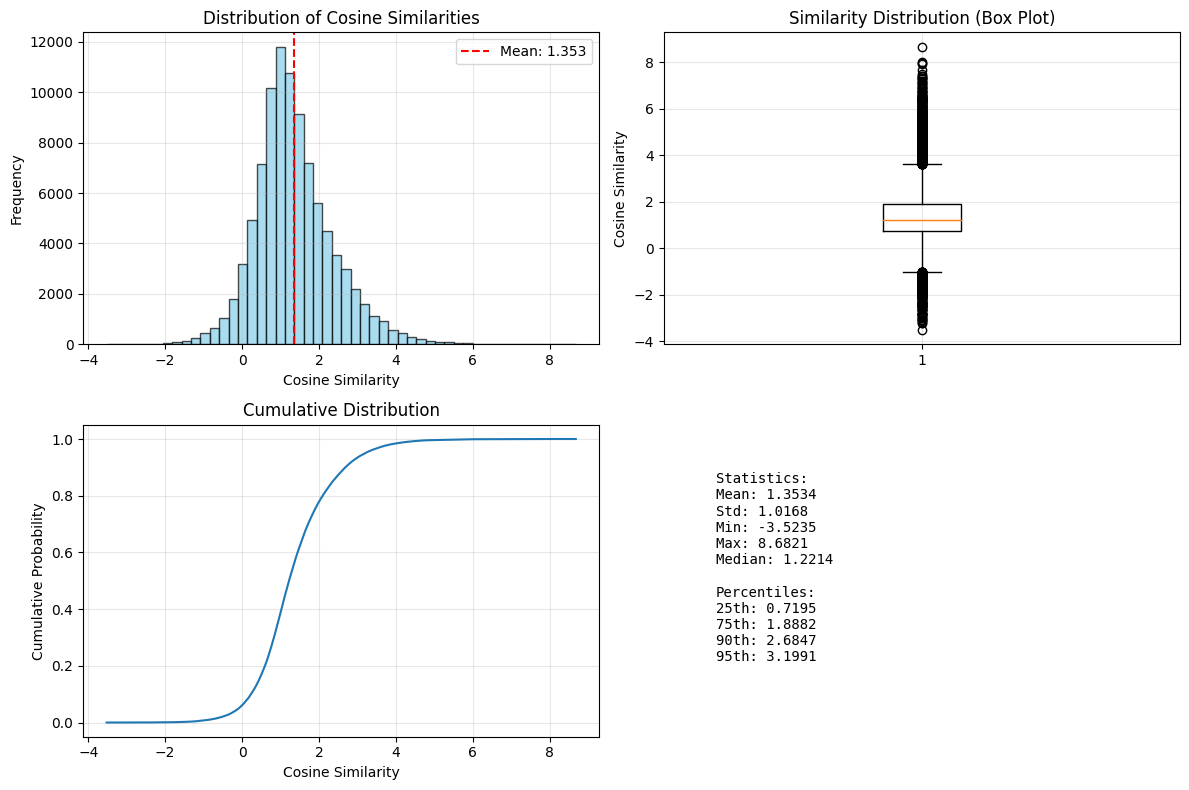

In [17]:
# Cell 13: Visualize similarity distribution
print("Creating similarity distribution plot...")

plt.figure(figsize=(12, 8))

# Main histogram
plt.subplot(2, 2, 1)
plt.hist(cosine_similarities, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities')
plt.axvline(np.mean(cosine_similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(cosine_similarities):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(2, 2, 2)
plt.boxplot(cosine_similarities)
plt.ylabel('Cosine Similarity')
plt.title('Similarity Distribution (Box Plot)')
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(2, 2, 3)
sorted_similarities = np.sort(cosine_similarities)
y_vals = np.arange(1, len(sorted_similarities) + 1) / len(sorted_similarities)
plt.plot(sorted_similarities, y_vals)
plt.xlabel('Cosine Similarity')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.grid(True, alpha=0.3)

# Statistics text
plt.subplot(2, 2, 4)
plt.axis('off')
stats_text = f"""
Statistics:
Mean: {np.mean(cosine_similarities):.4f}
Std: {np.std(cosine_similarities):.4f}
Min: {np.min(cosine_similarities):.4f}
Max: {np.max(cosine_similarities):.4f}
Median: {np.median(cosine_similarities):.4f}

Percentiles:
25th: {np.percentile(cosine_similarities, 25):.4f}
75th: {np.percentile(cosine_similarities, 75):.4f}
90th: {np.percentile(cosine_similarities, 90):.4f}
95th: {np.percentile(cosine_similarities, 95):.4f}
"""
plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'similarity_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

Analyzing feature distributions...


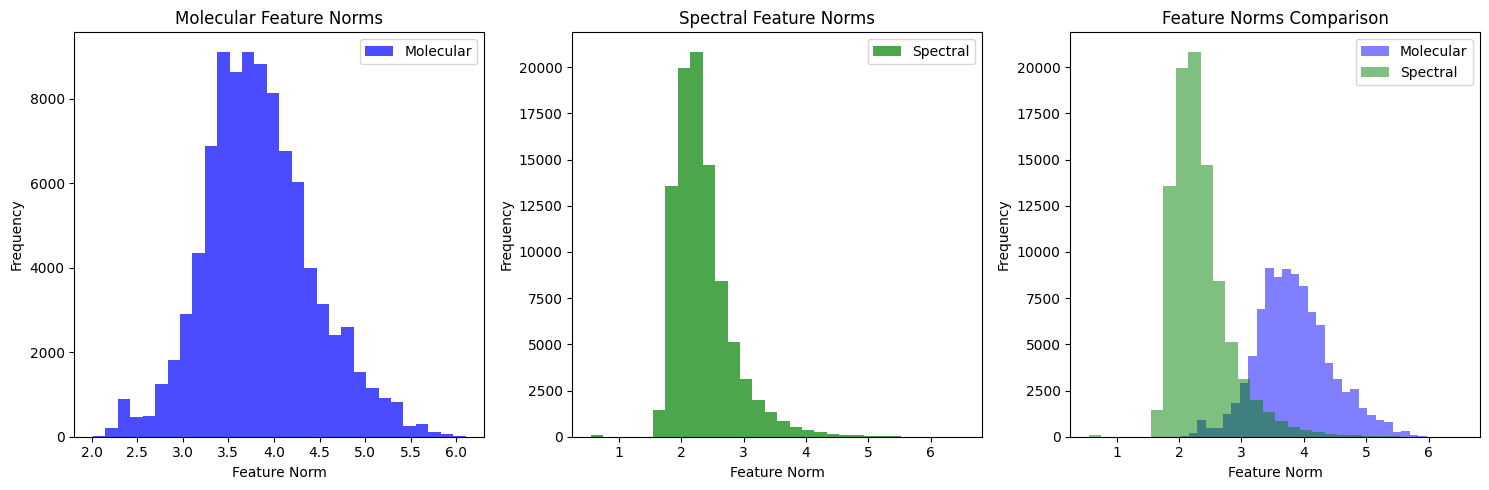

Molecular features - Mean norm: 3.8401, Std: 0.5982
Spectral features - Mean norm: 2.3479, Std: 0.4699


In [18]:
# Cell 14: Analyze feature distributions
print("Analyzing feature distributions...")

# Plot feature magnitude distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
mol_norms = np.linalg.norm(all_molecular_features, axis=1)
plt.hist(mol_norms, bins=30, alpha=0.7, label='Molecular', color='blue')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Molecular Feature Norms')
plt.legend()

plt.subplot(1, 3, 2)
spec_norms = np.linalg.norm(all_spectral_features, axis=1)
plt.hist(spec_norms, bins=30, alpha=0.7, label='Spectral', color='green')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Spectral Feature Norms')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(mol_norms, bins=30, alpha=0.5, label='Molecular', color='blue')
plt.hist(spec_norms, bins=30, alpha=0.5, label='Spectral', color='green')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Feature Norms Comparison')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_norms.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Molecular features - Mean norm: {np.mean(mol_norms):.4f}, Std: {np.std(mol_norms):.4f}")
print(f"Spectral features - Mean norm: {np.mean(spec_norms):.4f}, Std: {np.std(spec_norms):.4f}")